In [3]:
from skimage import io, filters, exposure, feature
from skimage.morphology import dilation, erosion, convex_hull_image
from skimage.measure import moments_central, moments_normalized, moments_hu
from skimage import img_as_float
from skimage.color import rgb2gray
import numpy as np
import os
import random
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Image Processing

In [4]:
def getMask(img): #Create mask for image
    mask = feature.canny(img) * 1.
    mask = convex_hull_image(mask)
    return mask

In [5]:
def preprocess(img): #Preprocess input image
    
    img = filters.gaussian(img, sigma=0.4)
    img = exposure.equalize_adapthist(img, clip_limit=0.03)
    
    return img

In [6]:
def process(img): #Process image looking for blood vessels
    img = filters.frangi(img)
    minimum = np.min(img)
    maximum = np.max(img)
    img = (img - minimum) / (maximum - minimum)
    img = img * (img>np.percentile(img, 80))
    img = (img>0) * 1.0
    return img

In [7]:
def postprocess(img, mask): #Postprocess image to improve found blood vessels, combine result with mask
    
    img = dilation(img)
    img = erosion(img)
    
    img = img*mask
    
    return img

In [8]:
def combine(img, res): #Combine result with input image
    init = img.copy()
    init[res==1, :] = 255
    return init

In [9]:
def showImg(img, fin, img_post, expected): #Show result of processing image, compare with expected result
    initial = io.imread("images/" + img)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (16,16))
    fig.suptitle(img, fontsize= 30)
    
    ax[0, 0].imshow(initial)
    ax[0, 0].set_title("Obraz wejściowy", fontsize= 20)
    ax[0, 0].axis("off")
    
    ax[0, 1].imshow(fin)
    ax[0, 1].set_title("Obraz wyjściowy", fontsize= 20)
    ax[0, 1].axis("off")
    
    ax[1, 0].imshow(img_post, cmap='gray')
    ax[1, 0].set_title("Otrzymana maska", fontsize= 20)
    ax[1, 0].axis("off")
    
    ax[1, 1].imshow(expected, cmap='gray')
    ax[1, 1].set_title("Oczekiwana maska", fontsize= 20)
    ax[1, 1].axis("off")

In [10]:
def stats(res, exp, mask): #Calculate statistics for received mask, comparing with expected result
    TP = 0 #TruePositive
    TN = 0 #TrueNegative
    FP = 0 #FalsePositive
    FN = 0 #FalseNegative
    for re, ex, mas in zip(res, exp, mask):
        for i, j, ma in zip(re, ex, mas):
            if ma == 1:
                if(i==j==1):
                    TP += 1
                elif(i==j==0):
                    TN += 1
                elif i==1 and j==0:
                    FP += 1
                elif i==0 and j==1:
                    FN += 1
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    mean_sens_spec = (sensitivity + specificity) / 2
    print("Accuracy: "+str(accuracy))
    print("Sensitivity: "+str(sensitivity))
    print("Specificity: "+str(specificity))
    print("Mean of sensitivity and specificity: "+str(mean_sens_spec))

In [11]:
def run(img): #Run program for given image
    initial = io.imread("images/" + img)
    img_gray = img_as_float(rgb2gray(initial))

    img_pre = preprocess(img_gray)
    mask = getMask(img_pre)
    img_proc = process(img_pre)
    img_post = postprocess(img_proc, mask)
    
    fin = combine(initial, img_post)
    
    expected = io.imread("results/" + img[:-4] + "_1stHO.png")
    expected = img_as_float(rgb2gray(expected))
    
    showImg(img, fin, img_post, expected)
    
    print("Statistics for " + img)
    stats(img_post, expected, mask)
    print("")
    plt.show()

In [12]:
def getRandom(amount = 5): #Choosing random images from main folder
    images=os.listdir(os.getcwd()+"\\images")
    chosenImages=random.sample(images, amount)
    names=[]
    for i in chosenImages:
        names.append(i)
    print(names)
    return names

### Run image processing

In [13]:
###RANDOM 5 IMAGES
names = getRandom()

['Image_10R.jpg', 'Image_01L.jpg', 'Image_09L.jpg', 'Image_04R.jpg', 'Image_03R.jpg']


In [14]:
###CHOOSE DATA
names = ['Image_14L.jpg', 'Image_02L.jpg', 'Image_04L.jpg', 'Image_03L.jpg', 'Image_01L.jpg']

Statistics for Image_14L.jpg
Accuracy: 0.9312996679124351
Sensitivity: 0.7829018134440286
Specificity: 0.9477135244734152
Mean of sensitivity and specificity: 0.8653076689587219



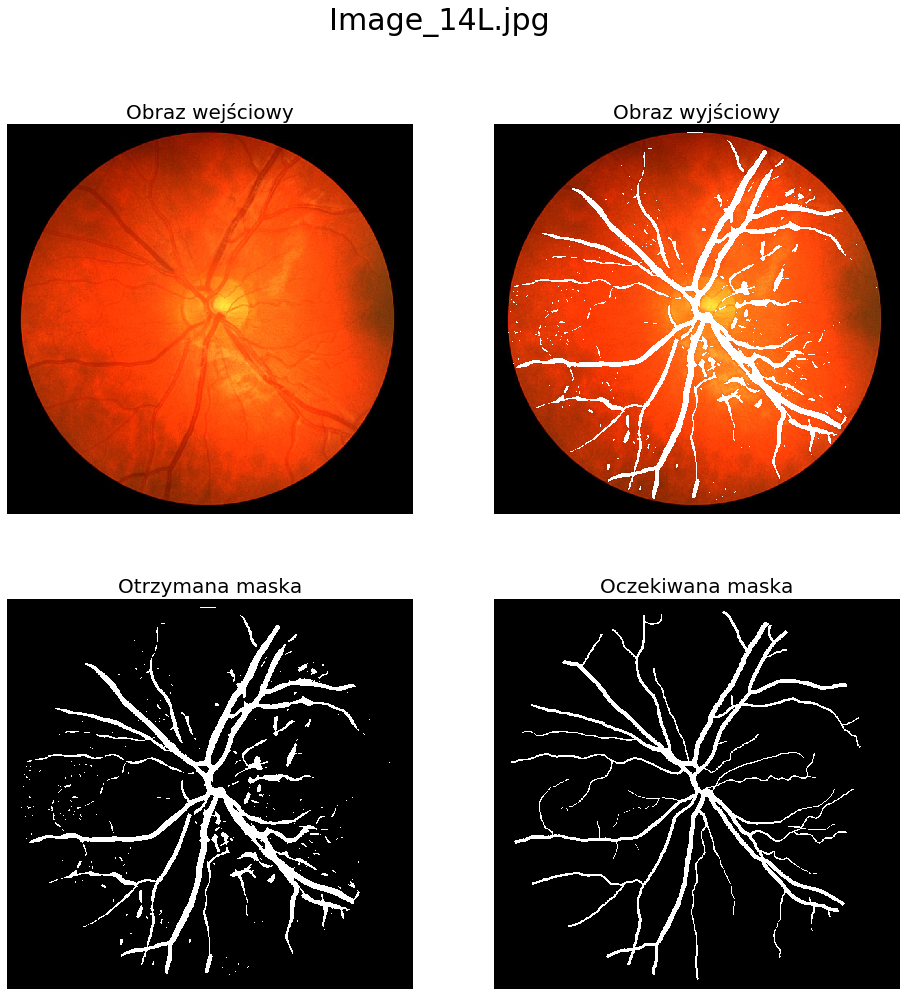

Statistics for Image_02L.jpg
Accuracy: 0.9027638736445983
Sensitivity: 0.6901118153243675
Specificity: 0.930951226342283
Mean of sensitivity and specificity: 0.8105315208333252



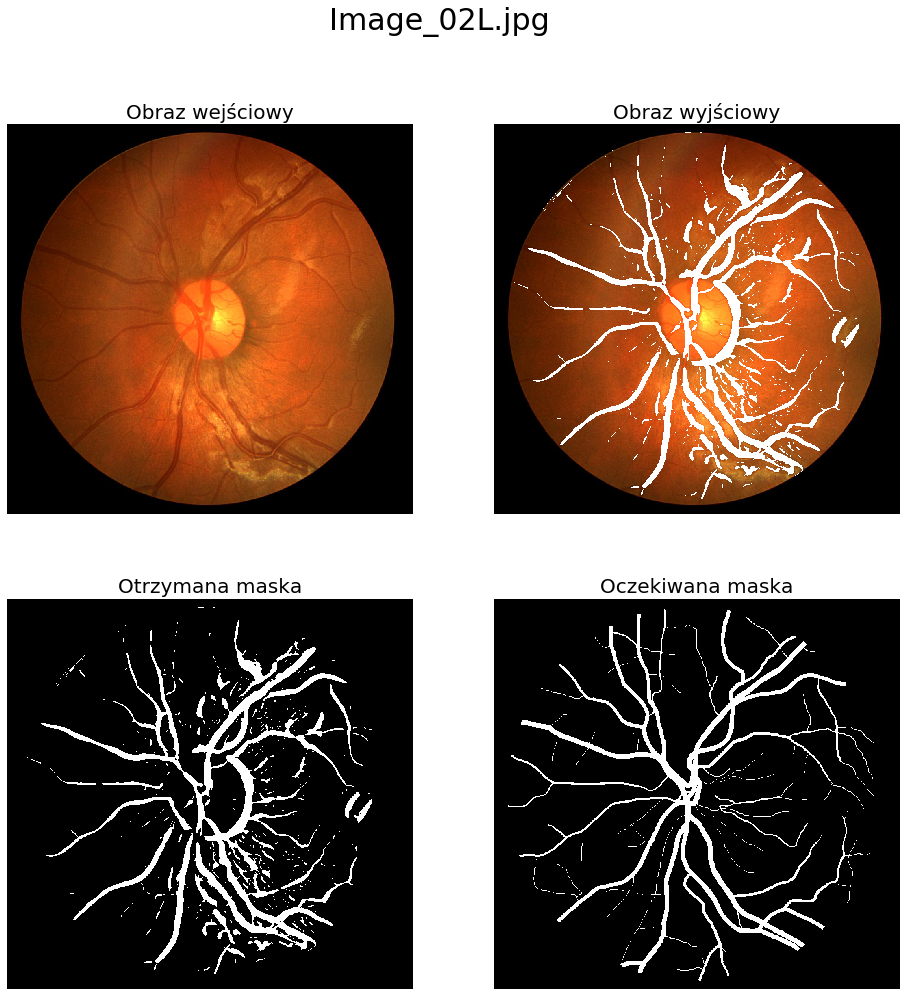

Statistics for Image_04L.jpg
Accuracy: 0.9249604756537592
Sensitivity: 0.7713779412156581
Specificity: 0.9446334124666557
Mean of sensitivity and specificity: 0.8580056768411568



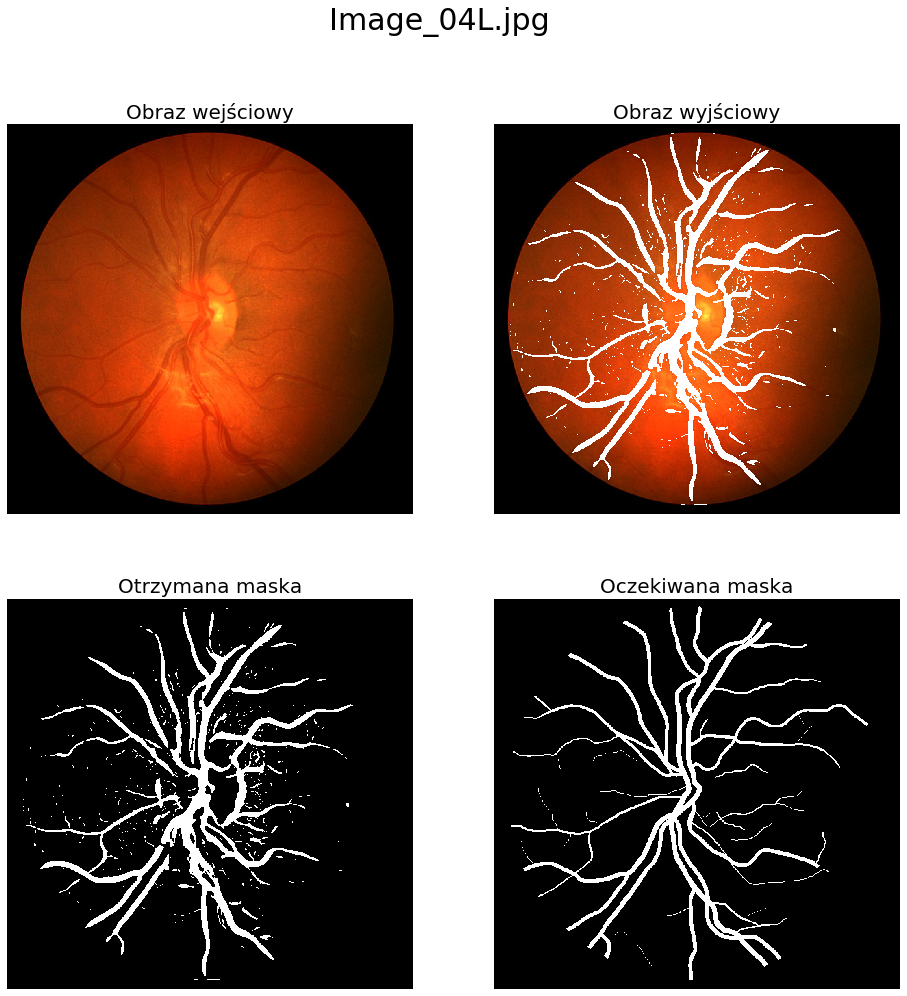

Statistics for Image_03L.jpg
Accuracy: 0.9131644158938838
Sensitivity: 0.75489725753578
Specificity: 0.933391237705965
Mean of sensitivity and specificity: 0.8441442476208725



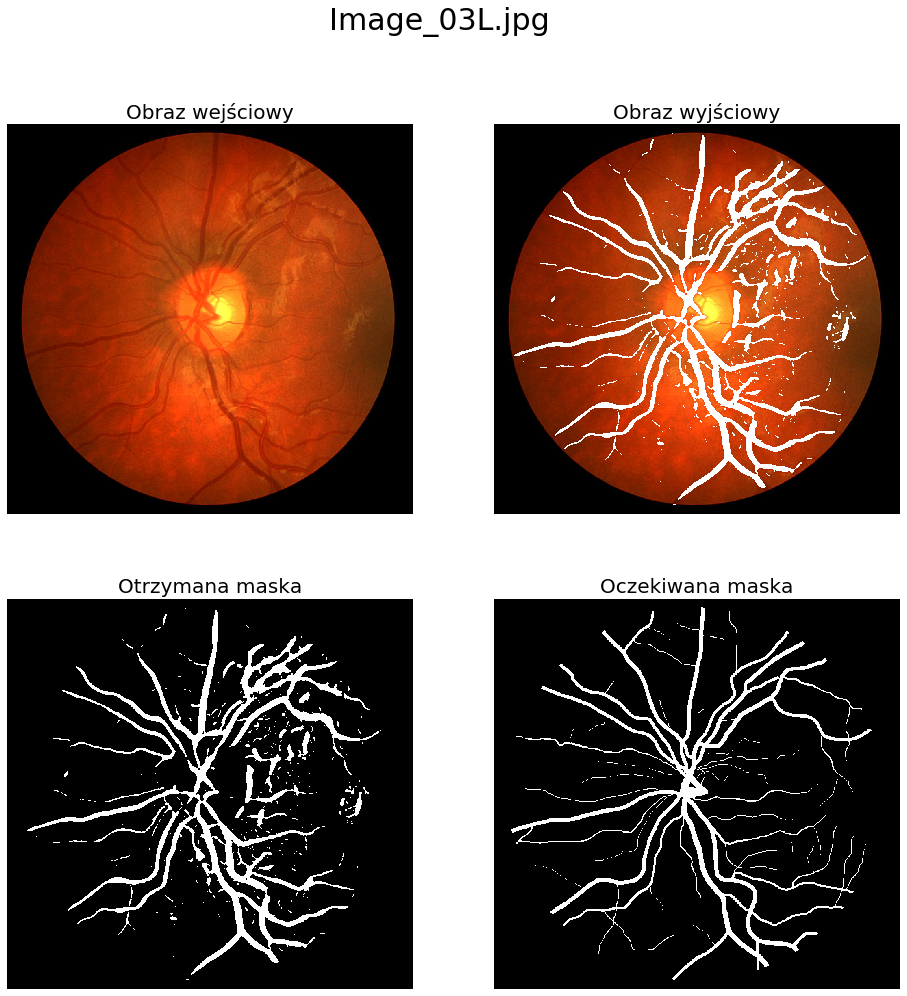

Statistics for Image_01L.jpg
Accuracy: 0.9078408055101141
Sensitivity: 0.7404439518303277
Specificity: 0.9265966516298803
Mean of sensitivity and specificity: 0.833520301730104



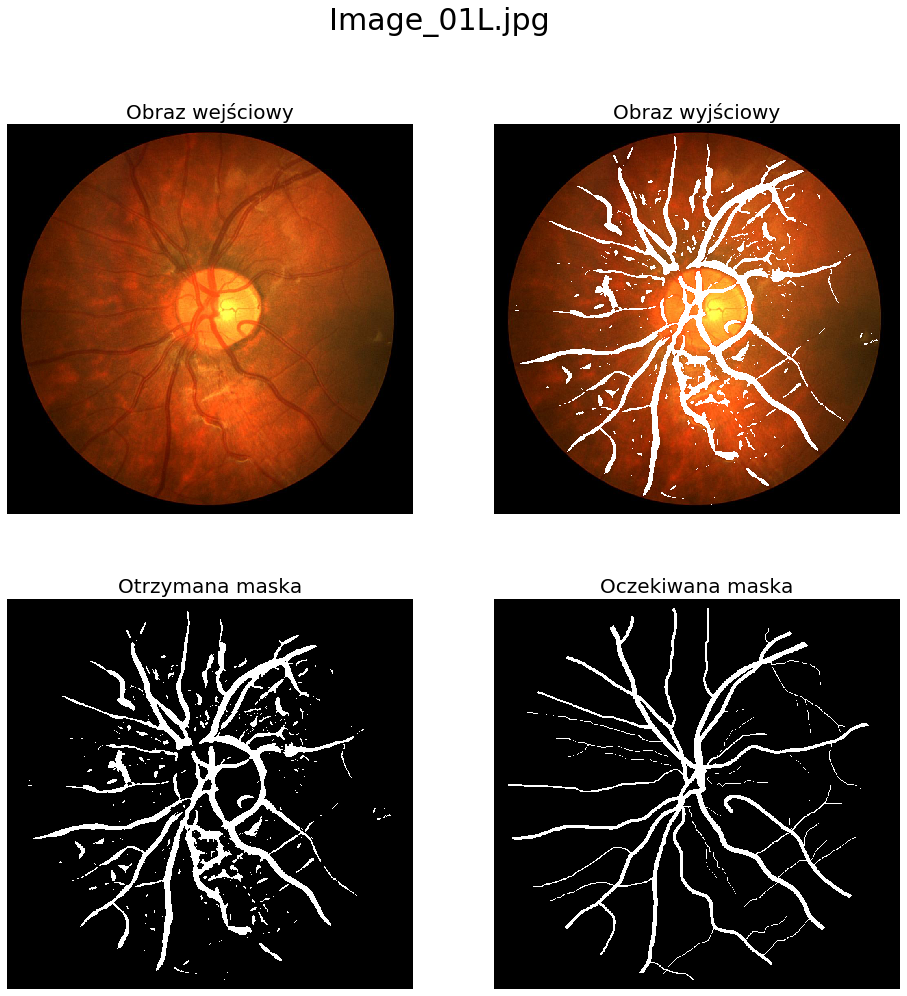

In [15]:
for name in names:
    run(name)

# Machine Learning

In [69]:
def partImg(size=5, amount=500):#Dividing images into size x size parts, collecting hu moment of parts for machine learning
    half = size//2
    images=['Image_08R.jpg', 'Image_09L.jpg', 'Image_07L.jpg', 'Image_13R.jpg', 'Image_11L.jpg', 'Image_14R.jpg']
    momentsPos = []
    momentsNeg = []
    for img in images:
        initial = io.imread("images/" + img)
        img_gray = img_as_float(rgb2gray(initial))
        img_pre = preprocess(img_gray)
        mask = getMask(img_pre)
        expected = io.imread("results/" + img[:-4] + "_1stHO.png")
        expected = img_as_float(rgb2gray(expected))
        
        momentPos = []
        momentNeg = []
        while len(momentPos) < amount/2 or len(momentNeg) < amount/2:
            x = random.randint(half, len(img_pre)-size+half)
            y = random.randint(half, len(img_pre[0])-size+half)
            if mask[x][y] == 1:
                if expected[x][y] == 1:
                    if len(momentPos) < amount/2:
                        mu = moments_central(img_pre[x-half:x+size-half, y-half:y+size-half])
                        nu = moments_normalized(mu)
                        hu = moments_hu(nu)                      
                        momentPos.append(hu)
                else:
                    if len(momentNeg) < amount/2:
                        mu = moments_central(img_pre[x-half:x+size-half, y-half:y+size-half])
                        nu = moments_normalized(mu)
                        hu = moments_hu(nu)
                        momentNeg.append(hu)
        momentsPos += momentPos
        momentsNeg += momentNeg
    info = np.ones(len(momentsPos) + len(momentsNeg))
    info[len(momentsPos):] = 0
    allMom = momentsPos + momentsNeg
    return info, allMom

In [17]:
def model4(X, y): #Create model using KNeighborsClassifier
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        shuffle=True,
        random_state=42,
    )
    model = KNeighborsClassifier(n_neighbors = 15)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))
    return model

In [64]:
def model5(X, y, k=5): #Create model using RandomForestClassifier with k-fold cross validation
    bestScore = 0.
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        shuffle=True,
        random_state=42,
    )
    kf = KFold(n_splits=k, shuffle = True, random_state = 42)
    model = RandomForestClassifier()
    val = []
    
    for train_index, test_index in kf.split(X_train):
        X_train_n, X_test_n = np.array(X_train)[train_index], np.array(X_train)[test_index]
        y_train_n, y_test_n = np.array(y_train)[train_index], np.array(y_train)[test_index]
        
        model.fit(X_train_n, y_train_n)
        acc = model.score(X_test_n, y_test_n)
        val.append(acc)
    acc = np.mean(val)
    print("[INFO] validation mean accuracy: {:.2f}%".format(acc * 100))
    acc = model.score(X_test, y_test)
    print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))
    return model

In [62]:
def imageModel(model, img, size=5): #Create mask for given image using given model
    half = size//2
    initial = io.imread("images/" + img)
    img_gray = img_as_float(rgb2gray(initial))
    img_pre = preprocess(img_gray)
    mask = getMask(img_pre)
    expected = io.imread("results/" + img[:-4] + "_1stHO.png")
    expected = img_as_float(rgb2gray(expected))
    
    predicted = np.zeros((len(img_pre), len(img_pre[0])))
    
    for x in range(half, len(img_pre) - size + half):
        tmp = []
        for y in range(half, len(img_pre[0]) - size + half):
            if mask[x][y] == 1:
                mu = moments_central(img_pre[x-half:x+size-half, y-half:y+size-half])
                nu = moments_normalized(mu)
                hu = moments_hu(nu)
                tmp.append(hu)
        if len(tmp) != 0:
            pred = model.predict(tmp)
            licz = 0
            for y in range(half, len(img_pre[0]) - size + half):
                if mask[x][y] == 1:
                    predicted[x][y] = pred[licz]
                    licz += 1
    
#     predicted = postprocess(predicted, mask)
    
    fin = combine(initial, predicted)
    
    showImg(img, fin, predicted, expected)
    print("Statistics for " + img)
    stats(predicted, expected, mask)
    print("")
    plt.show()

In [20]:
def getModel(grade = 5, size = 5, k = 20, amount = 500):
    info, allMom = partImg(size, amount)
    if grade == 5:
        model = model5(allMom, info, k)
    else:
        model = model4(allMom, info)
    return model

### Run machine learning

In [84]:
grade = 4 # [5, 4] - choose model: 4-kNN 5-Forest
size = 5 # divided image shape (size x size)
k = 10 # k Fold cross validation
amount =  150 # size of collected data from one image

In [87]:
model = getModel(grade, size, k, amount)

[INFO] histogram accuracy: 73.89%


In [ ]:
name = getRandom(1) # get random image or choose image
#name = "Image_04L.jpg"

In [ ]:
imageModel(model, name[0], size)

Statistics for Image_14L.jpg
Accuracy: 0.8574528084106721
Sensitivity: 0.6031633008620297
Specificity: 0.8855790337986159
Mean of sensitivity and specificity: 0.7443711673303228



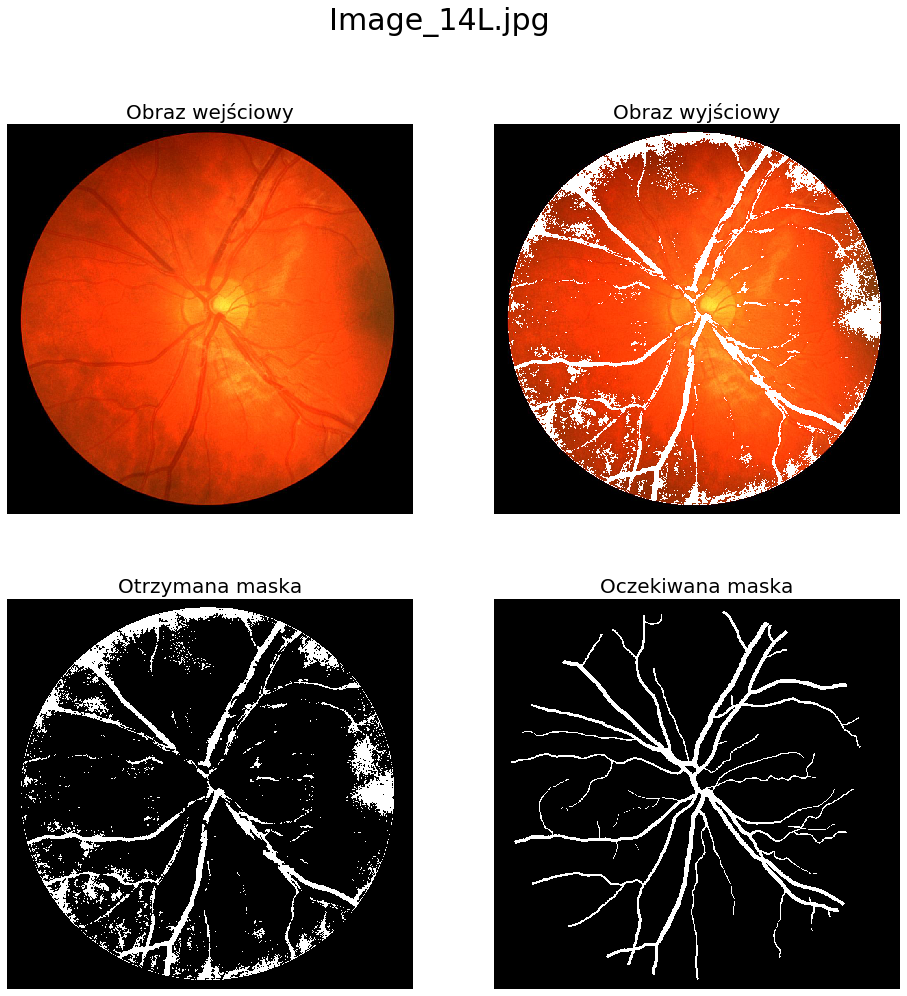

Statistics for Image_02L.jpg
Accuracy: 0.792115451880978
Sensitivity: 0.5913974339155975
Specificity: 0.8187209294383618
Mean of sensitivity and specificity: 0.7050591816769797



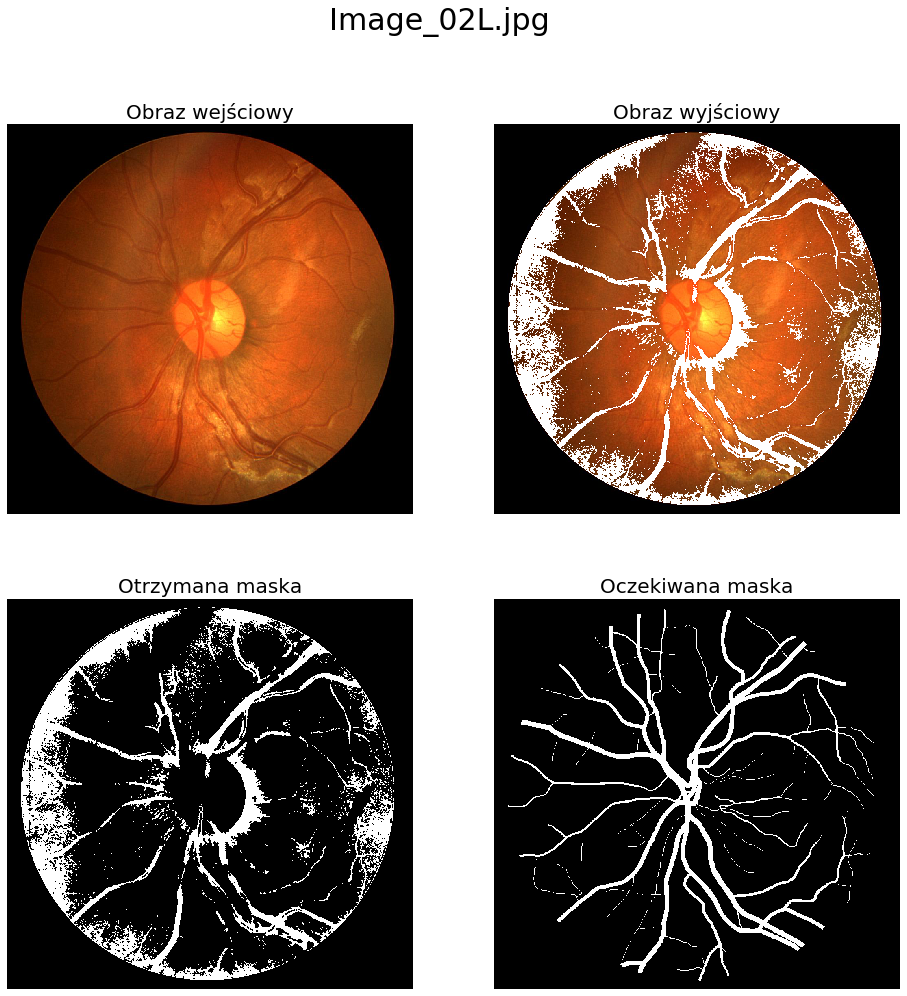

Statistics for Image_04L.jpg
Accuracy: 0.7785184232622525
Sensitivity: 0.5819143549977349
Specificity: 0.8037021424024331
Mean of sensitivity and specificity: 0.692808248700084



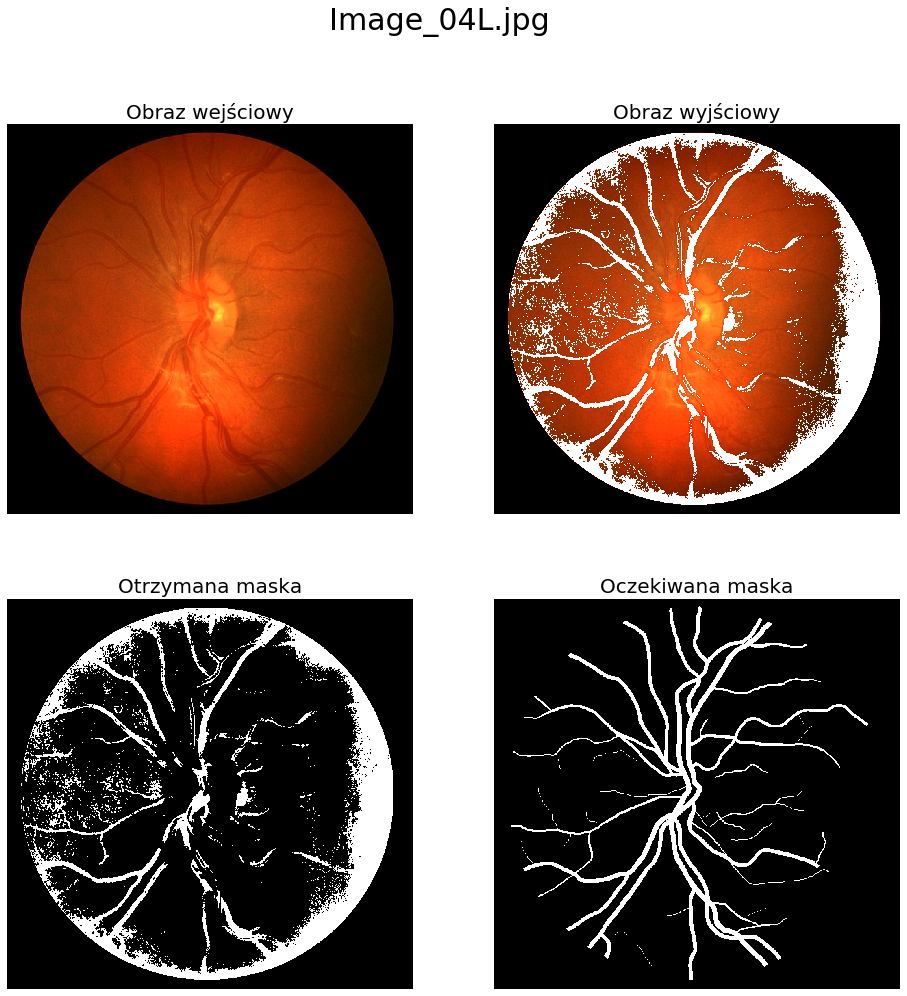

Statistics for Image_03L.jpg
Accuracy: 0.8001138599582917
Sensitivity: 0.6766210921883745
Specificity: 0.8158964533571763
Mean of sensitivity and specificity: 0.7462587727727754



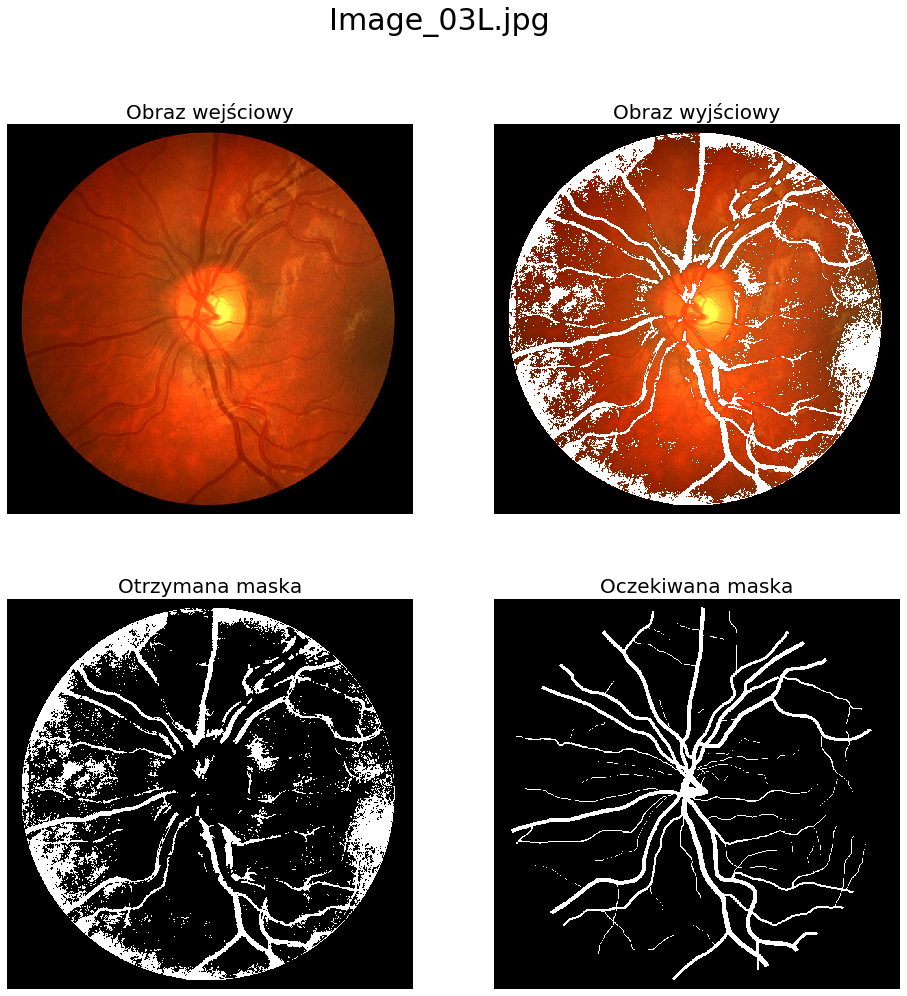

Statistics for Image_01L.jpg
Accuracy: 0.7579787394587677
Sensitivity: 0.6168743634293931
Specificity: 0.773788666022233
Mean of sensitivity and specificity: 0.695331514725813



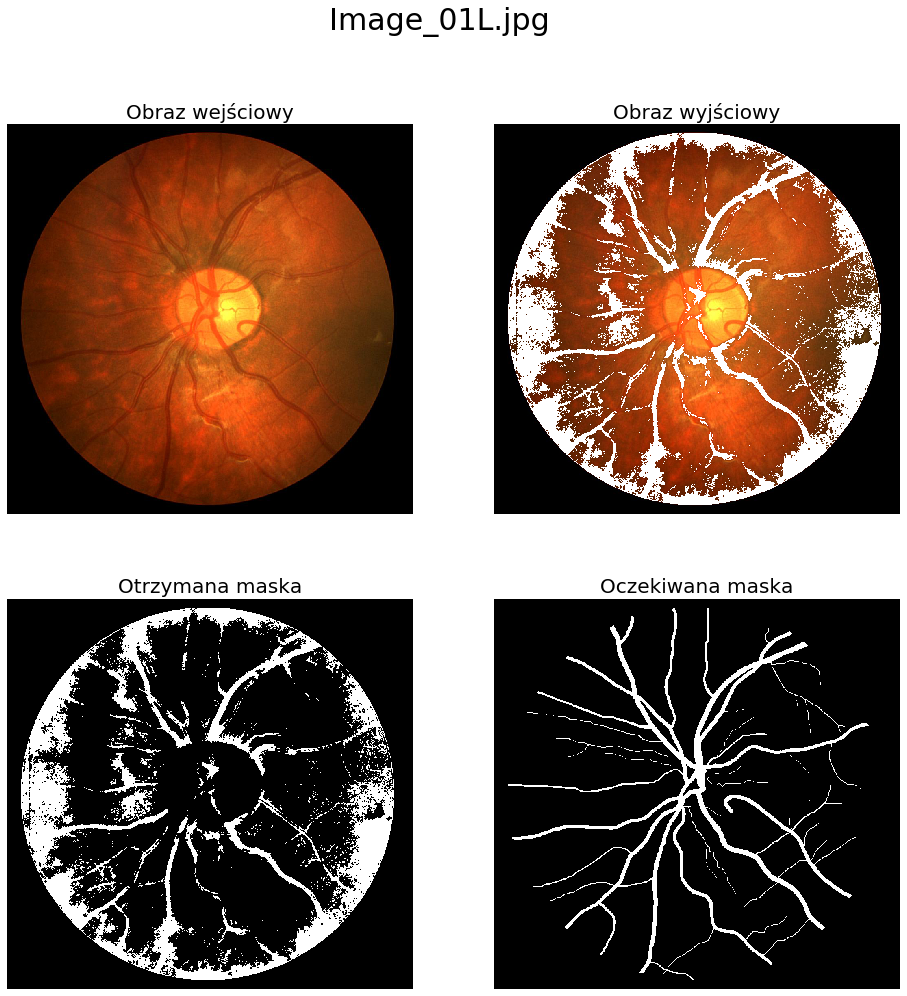

In [88]:
for name in names:
    imageModel(model, name, size)